##### Coding along with https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70
##### https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
##### https://blog.quantinsti.com/autoregression/

## ARIMAX Model

##### Import Modules

In [1]:
# module imports
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as tts
from joblib import load, dump

##### Read in csv to Pandas DataFrame

In [2]:
# read in csv to pd df
dataset = pd.read_csv('monthlydata.csv')

# set date as index
df = dataset.set_index(dataset['date'])

# remove extra columns
df.drop(columns=['VGT', 'VIS', 'VHT', 'VFH', 'VCR', 'date', 'Consumer Price Index for all Urban Consumers', 'Real Gross Domestic Product'], inplace=True)

In [3]:
# confirm df
df.head()

,10-Year Treasury Constant Maturity Rate,Inflation Expectations,Consumer Sentiment & Consumer Confidence,Advance Retail Sales: Retail Trade,Unemployment Rate,VTI
date,,,,,,
2006-01-01,4.42,3.0,91.2,286152.0,4.7,127.30
2006-02-01,4.57,3.0,86.7,282417.0,4.8,127.58
2006-03-01,4.72,3.0,88.9,326153.0,4.7,129.67
2006-04-01,4.99,3.3,87.4,316526.0,4.7,130.91
2006-05-01,5.11,4.0,79.1,337393.0,4.6,126.69


##### Plot Target Data

(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 [Text(-25.0, 0, '2020-02-01'),
  Text(0.0, 0, '2006-01-01'),
  Text(25.0, 0, '2008-02-01'),
  Text(50.0, 0, '2010-03-01'),
  Text(75.0, 0, '2012-04-01'),
  Text(100.0, 0, '2014-05-01'),
  Text(125.0, 0, '2016-06-01'),
  Text(150.0, 0, '2018-07-01'),
  Text(175.0, 0, '2020-08-01'),
  Text(200.0, 0, ''),
  Text(225.0, 0, '')])

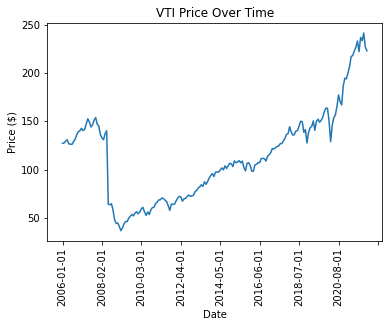

In [4]:
df['VTI'].plot( title='VTI Price Over Time', xlabel='Date', ylabel='Price ($)')
plt.xticks(rotation=90)

# strong linear trend, indicates non-stationary data

##### Split Data into Train/Test Sets

In [5]:
# split df into X and y
X = df.drop(columns='VTI').copy()
y = df['VTI'].copy()

# create tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.05, shuffle=False)

# confirm datetime for indices
for x in [X_train, X_test, y_train, y_test]:
    x.index = pd.to_datetime(x.index)

##### Check Assumptions

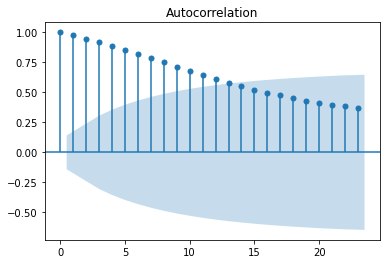

In [6]:
# check if target variable is autocorrelated
acfplot = plot_acf(y, alpha=0.05) # 95% confidence, blue region is confidence band

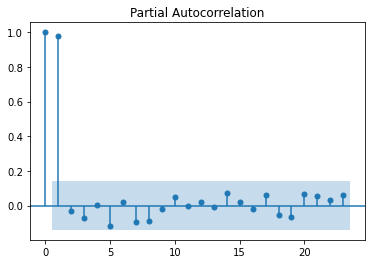

In [7]:
# plot partial auto correlation
pacfplot = plot_pacf(y, alpha=0.05)

p-value: 0.97


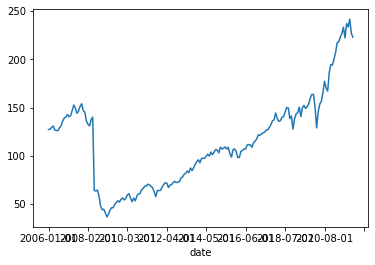

In [8]:
# check if data is stationary using Dickey-Fuller test
result = adfuller(y)
y.plot()
print('p-value: %.2f' % result[1])

# since the p-value = 0.97 > 0.05, the data is NOT stationary

### Get p, d, q values

p-value: 0.00


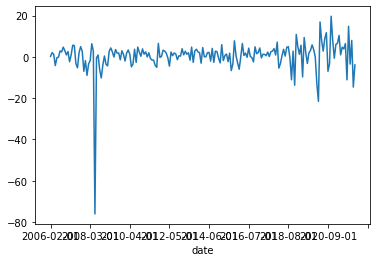

In [9]:
# check stationality of first difference
# https://towardsdatascience.com/arima-model-in-python-7bfc7fb792f9
# https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/#:~:text=To%20implement%20the%20ADF%20test%20in%20python%2C%20we,The%20function%20to%20perform%20ADF%20is%20called%20adfuller.
ydiff1 = y-y.shift(1)
# remove NaN from y1
ydiff1 = ydiff1.drop(['2006-01-01'])

result1 = adfuller(ydiff1)
ydiff1.plot()
print('p-value: %.2f' % result1[1]) 

# whoo! stationary after 1st difference, so d = 1

Text(0.5, 1.0, 'Stationality of VTI Price vs First Difference VTI Prices')

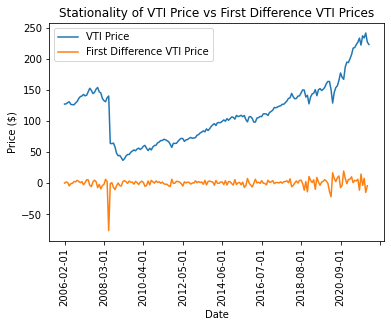

In [10]:
# visualize stationality
y.plot(xlabel= 'Date', label='VTI Price')
ydiff1.plot(xlabel= 'Date', label='First Difference VTI Price')
plt.xticks(rotation=90)
plt.ylabel('Price ($)')
plt.legend()
plt.title('Stationality of VTI Price vs First Difference VTI Prices')

Text(0.5, 0, 'Lags')

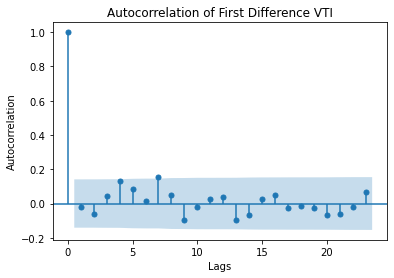

In [11]:
# check for autocorrelation of 1st difference (MA)
acfplot1 = plot_acf(ydiff1, alpha=0.05)
plt.title(label='Autocorrelation of First Difference VTI')
plt.ylabel('Autocorrelation')
plt.xlabel('Lags')

# lag 7, so q = 7

Text(0.5, 0, 'Lags')

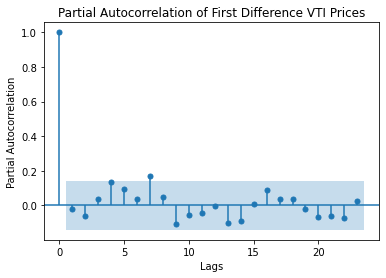

In [12]:
# check for partial autocorrelation of 1st difference (AR)
pacfplot1 = plot_pacf(ydiff1, alpha=0.05)
plt.title(label='Partial Autocorrelation of First Difference VTI Prices')
plt.ylabel('Partial Autocorrelation')
plt.xlabel('Lags')

# lag 7, so p = 7

##### Train Model and Get Predictions

In [13]:
trained = ARIMA(y_train, exog=X_train, order=(7,1,7)).fit()
start = len(X_train)
end = len(X_train) + len(X_test) - 1
arimax_results = trained.predict(start, end, exog=X_test)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


##### Plot Predictions vs Actual Results

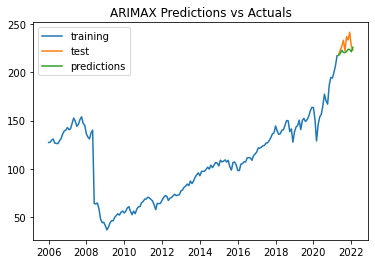

In [14]:
plt.plot(y_train, label='training')
plt.plot(y_test, label='test')
plt.plot(arimax_results, label='predictions')
plt.title('ARIMAX Predictions vs Actuals')
plt.legend()
plt.show()

##### Check Model Stats

In [15]:
trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VTI   No. Observations:                  184
Model:                 ARIMA(7, 1, 7)   Log Likelihood                -617.201
Date:                Wed, 16 Feb 2022   AIC                           1274.402
Time:                        16:14:47   BIC                           1338.592
Sample:                    01-01-2006   HQIC                          1300.422
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
10-Year Treasury Constant Maturity Rate      2.0835      4.933      0.422      0.673      -7.584      11.751
Inflation Expectations                       2.5235      4.052      0.623      0.533      -5.418      10.465
Consumer Sentiment & Consumer Confidence     0.1921      0.300      0.640      0.522      -0.396       0.780
Advance Retail Sales: Retail Trade       -3.123e-06   3.64e-05     -0.086      0.932   -7.44e-05    6.82e-05
Unemployment Rate                            1.1275      0.924      1.220      0.222      -0.684       2.939
ar.L1                                        0.0563      0.777      0.072      0.942      -1.467       1.580
ar.L2                                       -0.3445      0.669     -0.515      0.607      -1.655       0.966
ar.L3                                       -0.1298      0.632     -0.205      0.837      -1.369       1.110
ar.L4                                        0.0779      0.601      0.130      0.897      -1.099       1.255
ar.L5                                        0.2442      0.574      0.425      0.671      -0.881       1.369
ar.L6                                       -0.2531      0.670     -0.378      0.706      -1.566       1.060
ar.L7                                        0.2285      0.721      0.317      0.751      -1.185       1.642
ma.L1                                       -0.0668      0.774     -0.086      0.931      -1.584       1.451
ma.L2                                        0.2673      0.681      0.392      0.695      -1.068       1.603
ma.L3                                        0.2298      0.647      0.355      0.722      -1.037       1.497
ma.L4                                       -0.0528      0.664     -0.080      0.937      -1.354       1.248
ma.L5                                       -0.1432      0.604     -0.237      0.813      -1.328       1.042
ma.L6                                        0.3097      0.686      0.451      0.652      -1.035       1.655
ma.L7                                        0.0115      0.765      0.015      0.988      -1.487       1.510
sigma2                                      55.6387      4.094     13.589      0.000      47.614      63.663
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             27719.31
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -6.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
arimax_error = mean_squared_error(arimax_results, y_test)**0.5

### Export model

In [17]:
dump(trained, 'arimax model')

['arimax model']